In [ ]:
#| hide

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# AutoTheta Model

> Step-by-step guide on using the `AutoTheta Model` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

## Table of Contents

* [Introduction](#introduction)
* [Theta Models](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of AutoTheta with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction<a class="anchor" id="introduction"></a>

The development of accurate, robust and reliable forecasting methods for univariate time series is very important when large numbers of time series are involved in the modelling and forecasting process. In industrial settings, it is very common to work with large lines of products; thus, efficient sales and operational planning (S&OP) depend heavily on accurate forecasting methods.

The Theta method [(Assimakopoulos & Nikolopoulos, 2000, hereafter A&N)](https://www.sciencedirect.com/science/article/abs/pii/S0169207000000662) is applied to non-seasonal or deseasonalised time series, where the deseasonalisation is usually performed via the multiplicative classical decomposition. The method decomposes the original time series into two new lines through the so-called theta coefficients, denoted by ${\theta}_1$ and ${\theta}_2$ for ${\theta}_1, {\theta}_2 \in \mathbb{R}$, which are applied to the second difference of the data. The second differences are reduced when ${\theta}<1$, resulting in a better approximation of the long-term behaviour of the series (Assimakopoulos, 1995). If ${\theta}$ is equal to zero, the new line is a straight line. When ${\theta}>1$ the local curvatures are increased, magnifying the short-term movements of the time series (A&N). The new lines produced are called theta lines, denoted here by $\text{Z}(\theta_1)$ and $\text{Z}(\theta_2)$. These lines have the same mean value and slope as the original data, but the local curvatures are either filtered out or enhanced, depending on the value of the $\theta$ coefficient.

In other words, the decomposition process has the advantage of exploiting information in the data that usually cannot be captured and modelled completely through the extrapolation of the original time series. The theta lines can be regarded as new time series and are extrapolated separately using an appropriate forecasting method. Once the extrapolation of each theta line has been completed, recomposition takes place through a combination scheme in order to calculate the point forecasts of the original time series. Combining has long been considered as a useful practice in the forecasting literature (for example,  [Clemen, 1989, Makridakis and Winkler, 1983, Petropoulos et al., 2014]()), and therefore its application to the Theta method is expected to result in more accurate and robust forecasts.



The Theta method is quite versatile in terms of choosing the number of theta lines, the theta coefficients and the extrapolation methods, and combining these to obtain robust forecasts. However, A&N proposed a simplified version involving the use of only two theta lines with prefixed $\theta$ coefficients that are extrapolated over time using a linear regression (LR) model for the theta line with ${\theta}_1 =0$ and simple exponential smoothing (SES) for the theta line with ${\theta}_2 =2$. The final forecasts are produced by combining the forecasts of the two theta lines with equal weights.

The performance of the Theta method has also been confirmed by other empirical studies (for example Nikolopoulos et al., 2012, Petropoulos and Nikolopoulos, 2013). Moreover, Hyndman and Billah (2003), hereafter H&B, showed that the simple exponential smoothing with drift model (SES-d) is a statistical model for the simplified version of the Theta method. More recently, Thomakos and Nikolopoulos (2014) provided additional theoretical insights, while Thomakos and Nikolopoulos (2015) derived new theoretical formulations for the application of the method to multivariate time series, and investigated the conditions under which the bivariate Theta method is expected to forecast better than the univariate one. Despite these advances, we believe that the Theta method deserves more attention from the forecasting community, given its simplicity and superior forecasting performance.

One key aspect of the Theta method is that, by definition, it is dynamic. One can choose different theta lines and combine the produced forecasts using either equal or unequal weights. However, AN limit this important property by fixing the theta coefficients to have predefined values.

The contributions of this work are fourfold. First, we extend the A&N method by the optimal selection of the theta line that describes the short-term movements of the series best, maintaining the long-term component. The forecasts derived from the two theta lines are combined using appropriate weights, which ensures the recomposition of the original time series. Second, we provide theoretical and practical links between the newly proposed model, the original Theta method and the SES-d model. Third, we also perform a further extension of the model that allows the regression line (the long term component) to be revised at every time period.

## Theta method <a class="anchor" id="model"></a>

### The original Theta method
Originally, AN proposed the theta line as the solution of the equation

$$
\begin{equation}
    \nabla^2 \text{Z}_t (\theta) =\theta \nabla^2 Y_t, \ \ t=3, \cdots, n \tag 1
\end{equation}
$$

where $Y_1, \cdots Y_n$ is the original time series (non-seasonal or deseasonalised) and $\nabla$ is the difference operator (i.e., $\nabla X_t = X_t - X_{t-1}$). The initial values of $\text{Z}_1$ and $\text{Z}_2$ are obtained by minimising $\sum_{t=1}^n [Y_t -\text{Z}_t(\theta)]^2$. However, an analytical solution to compute the $\text{Z}(\theta)$ was obtained by H&B, which is given by

$$
\begin{equation}
    \text{Z}_t(\theta)=\theta Y_t +(1-\theta)(A_n +B_n t) \ \ t=1, \cdots n \tag 2
\end{equation}
$$

where $\text{A}_n$ and $\text{B}_n$ are the minimum square coefficients of a simple linear regression over $Y_1, \cdots Y_n$ against $1, \cdots n \$, given by

$$
\begin{equation}
    \text{A}_n =\frac{1}{n} \sum_{t=1}^{n} Y_t -\frac{n+1}{2} \text{B}_n ; \ \ \text{B}_n= \frac{6}{n^2 -1} (\frac{2}{n} \sum_{t=1}^{n} tY_t -\frac{1+n}{n} \sum_{t=1}^{n} Y_t ) \tag 3
\end{equation}
$$

From this point of view, the theta lines can be interpreted as functions of the linear regression model applied to the data directly. However, note that $\text{A}_n$ and $\text{B}_n$ are only functions of the original data, not parameters of the Theta method.

Finally, the forecasts produced by the Theta method for $h$ steps ahead of  are an ad-hoc combination (50%-50%) of the extrapolations of $\text{Z}(0)$ and $\text{Z}(2)$ by the linear regression model and the simple exponential smoothing model respectively. We will refer to the above setup as the standard Theta method (STheta).

The steps for building the STheta method of AN are as follows:
1. Deseasonalisation: The time series is tested for statistically significant seasonal behaviour. A time series is seasonal if
$$|r_m|>q_{1-\alpha/2} \sqrt{\frac{1+2 \sum_{i=1}^{m-1} r_{i}^2}{n} }$$
 
where $r_k$ denotes the lag $k$ autocorrelation function, $m$ is the number of the periods within a seasonal cycle (for example, 12 for monthly data), $n$ is the sample size, $q$ is the quantile function of the standard normal distribution, and $(1-\alpha)\%$ is the confidence level. A&N opted for a 90% confidence level. If the time series is identified as seasonal, then it is deseasonalised via the classical decomposition method, assuming the seasonal component to have a multiplicative relationship.

2. Decomposition: The seasonally adjusted time series is decomposed into two theta lines, the linear regression line $\text{Z}(0)$ and the theta line $\text{Z}(2)$.

3. Extrapolation: $\text{Z}(0)$ is extrapolated as a normal linear regression line, while $\text{Z}(2)$ is extrapolated using SES.

4. Combination: The final forecast is a combination of the forecasts of the two theta lines using equal weights.

5. Reseasonalisation: If the series was identified as seasonal in step 1, then the final forecasts are multiplied by the respective seasonal indices.

### Models for optimising the Theta method

Assume that either the time series $Y_1, \cdots Y_n$ is non-seasonal or it has been seasonally adjusted using the multiplicative classical decomposition approach. 

Let $X_t$ be the linear combination of two theta lines,

$$
\begin{equation}
    X_t=\omega \text{Z}_t (\theta_1) +(1-\omega) \text{Z}_t (\theta_2) \tag 4
\end{equation}
$$

where $\omega \in [0,1]$ is the weight parameter. Assuming that $\theta_1 <1$ and $\theta_2 \geq 1$, the weight $\omega$ can be derived as

$$
\begin{equation}
    \omega:=\omega(\theta_1, \theta_2)=\frac{\theta_2 -1}{\theta_2 -\theta_1} \tag 5
\end{equation}
$$

It is straightforward to see from Eqs. (4), (5) that $X_t=Y_t, \ t=1, \cdots n$ i.e., the weights are calculated properly in such a way that Eq. (4) reproduces the original series. In Theorem 1 of [Appendix A](https://www.sciencedirect.com/science/article/pii/S0169207016300243#s000075) , we prove that the solution is unique and that the error from not choosing the optimal weights ($\omega$ and $1-\omega$) s proportional to the error of a linear regression model. As a consequence, the STheta method is given simply by setting $\theta_1=0$ and $\theta_2=2$ while from Eq. (5) we get $\omega=0.5$. Thus, Eqs. (4), (5) allow us to construct a generalisation of the Theta model that maintains the re-composition propriety of the original time series for any theta lines $\text{Z}_t (\theta_1)$ and $\text{Z}_t (\theta_2)$.



In order to maintain the modelling of the long-term component and retain a fair comparison with the STheta method, in this work we fix $\theta_1=0$ and focus on the optimisation of the short-term component, $\theta_2=0$ with $\theta \geq 1$. Thus, $\theta$ is the only parameter that requires estimation so far. The theta decomposition is now given by

$$Y_t=(1-\frac{1}{\theta}) (\text{A}_n+\text{B}_n t)+ \frac{1}{\theta} \text{Z}_t (\theta), \ t=1, \cdots , n$$

The $h$ -step-ahead forecasts calculated at origin  are given by

$$
\begin{equation}
    \hat Y_{n+h|n} = (1-\frac{1}{\theta}) [\text{A}_n+\text{B}_n (n+h)]+ \frac{1}{\theta} \tilde {\text{Z}}_{n+h|n} (\theta) \tag 6
\end{equation}
$$

where $\tilde {\text{Z}}_{n+h|n} (\theta)=\tilde {\text{Z}}_{n+1|n} (\theta)=\alpha \sum_{i=0}^{n-1}(1-\alpha)^i \text{Z}_{n-i}(\theta)+(1-\alpha)^n \ell_{0}^{*}$ is the extrapolation of $\text{Z}_t(\theta)$ by an SES model with $\ell_{0}^{*} \in \mathbb{R}$ as the initial level parameter and $\alpha \in (0,1)$ as the smoothing parameter. Note that for $\theta=2$ Eq. (6) corresponds to Step 4 of the STheta algorithm. After some algebra, we can write

$$
\begin{equation}
    \tilde {\text{Z}}_{n+1|n} (\theta)=\theta \ell{n}+(1-\theta) \{ \text{A}_n [1-(1-\alpha)^n] + \text{B}_n [n+(1-\frac{1}{\alpha}) [1-(1-\alpha)^n] ]  \}   \tag 7
\end{equation}
$$

where $\ell_{t}=\alpha Y_t +(1-\alpha) \ell_{t-1}$ for $t=1, \cdots, n$ and $\ell_{0}=\ell_{0}^{*}/\theta$.

In the light of Eqs. (6), (7), we suggest four stochastic approaches. These approaches differ due to the parameter $\theta$ which may be either fixed at two or optimised, and the coefficients $\text{A}_n$ and $\text{B}_n$, which can be either fixed or dynamic functions. To formulate the state space models, it is helpful to adopt $\mu_{t}$ as the one-step-ahead forecast at origin $t-1$ and $\varepsilon_{t}$ as the respective additive error, i.e., $\varepsilon_{t}=Y_t - \mu_{t}$ if $\mu_{t}= \hat Y_{t|t-1}$. We assume $\{  \varepsilon_{t} \}$ to be a Gaussian white noise process with mean zero and variance $\sigma^2$. 

### Optimised and standard Theta models

Let $\text{A}_n$ and $\text{B}_n$ be fixed coefficients for all $t=1, \cdots, n$ so that Eqs. (6), (7) configure the state space model given by

$$
\begin{equation}
    Y_t=\mu_{t}+\varepsilon_{t} \tag 8
\end{equation}
$$ 

$$
\begin{equation}
    \mu_{t}=\ell_{t-1}+(1-\frac{1}{\theta}) \{(1-\alpha)^{t-1} \text{A}_n +[\frac{1-(1-\alpha)^t}{\alpha} \text{B}_n]  \tag 9 \}
\end{equation}
$$

$$
\begin{equation}
    \ell_{t}=\alpha Y_t +(1-\alpha)\ell_{t-1} \tag{10}
\end{equation}
$$

with parameters $\ell_{0} \in \mathbb{R}$, $\alpha \in (0,1)$ and $\theta \in [1,\infty)$ . The parameter $\theta$ is to be estimated along with $\alpha$ and $\ell_{0}$ We call this the optimised Theta model (OTM).

The $h$-step-ahead forecast at origin $n$ is given by

$$\hat Y_{n+h|n}=E[Y_{n+h}|Y_1,\cdots, Y_n]=\ell_{n}+(1-\frac{1}{\theta}) \{(1-\alpha)^n \text{A}_n +[(h-1) + \frac{1-(1-\alpha)^{n+1}}{\alpha}] \text{B}_n \}$$

which is equivalent to Eq. (6). The conditional variance $\text{Var}[Y_{n+h}|Y_1, \cdots, Y_n]=[1+(h-1)\alpha^2]\sigma^2$ can be computed easily from the state space model. Thus, the $(1-\alpha)\%$ prediction interval for $Y_{n+h}$ is given by
$$\hat Y_{n+h|n} \ \pm  \ q_{1-\alpha/2} \sqrt{[1+(h-1)\alpha^2 ]\sigma^2 }$$

For $\theta=2$ OTM reproduces the forecasts of the STheta method; hereafter, we will refer to this particular case as the standard Theta model (STM). In Theorem 2 of [Appendix A](https://www.sciencedirect.com/science/article/pii/S0169207016300243#s000075), we show that OTM is mathematically equivalent to the SES-d model. As a corollary of Theorem 2, STM is mathematically equivalent to SES-d with $b=\frac{1}{2} \text{B}_n$. Therefore, for $\theta=2$ the corollary also re-confirms the H&B result on the relationship between STheta and the SES-d model.


## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} 
Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation.ipynb). 
:::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import pandas as pd

import scipy.stats as stats

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)


### Read Data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/candy_production.csv")
df.head()

,observation_date,IPG3113N
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,1972-01-01,85.6945,1
1,1972-02-01,71.8200,1
2,1972-03-01,66.0229,1
3,1972-04-01,64.5645,1
4,1972-05-01,65.0100,1


In [ ]:
print(df.dtypes)

ds            object
y            float64
unique_id     object
dtype: object


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore Data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints aa random series from the dataset and is useful for basic EDA.

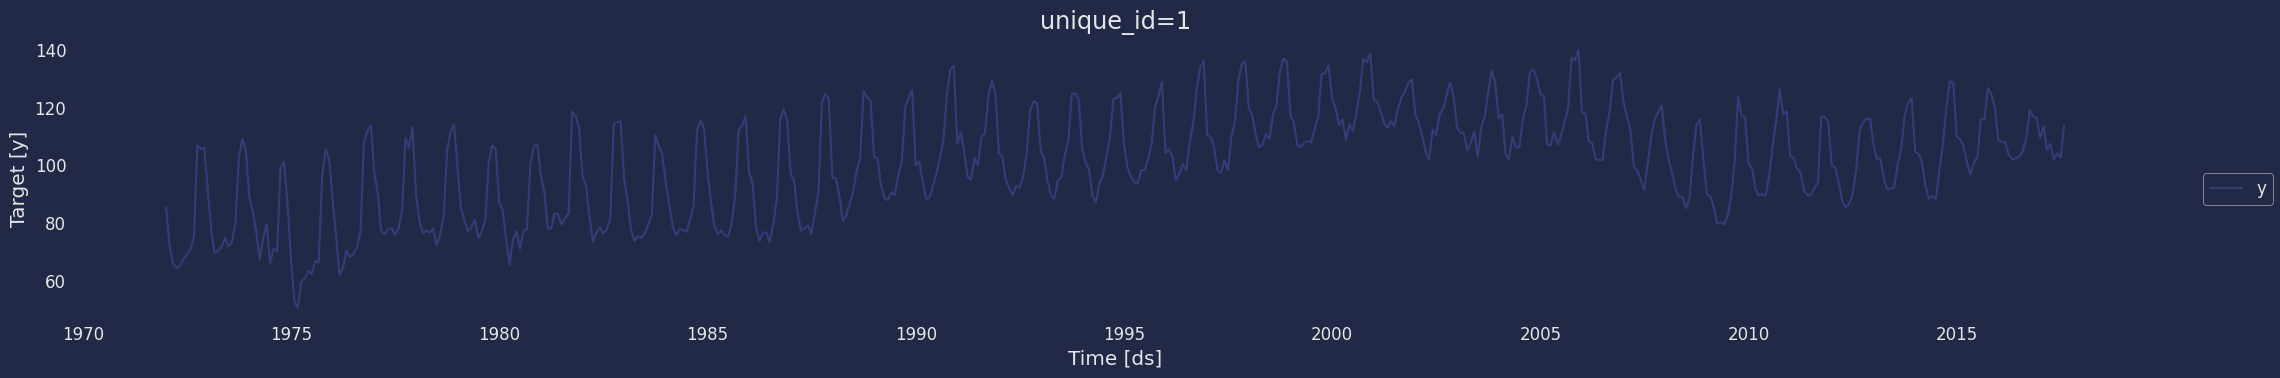

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df, engine="matplotlib")

### Autocorrelation plots

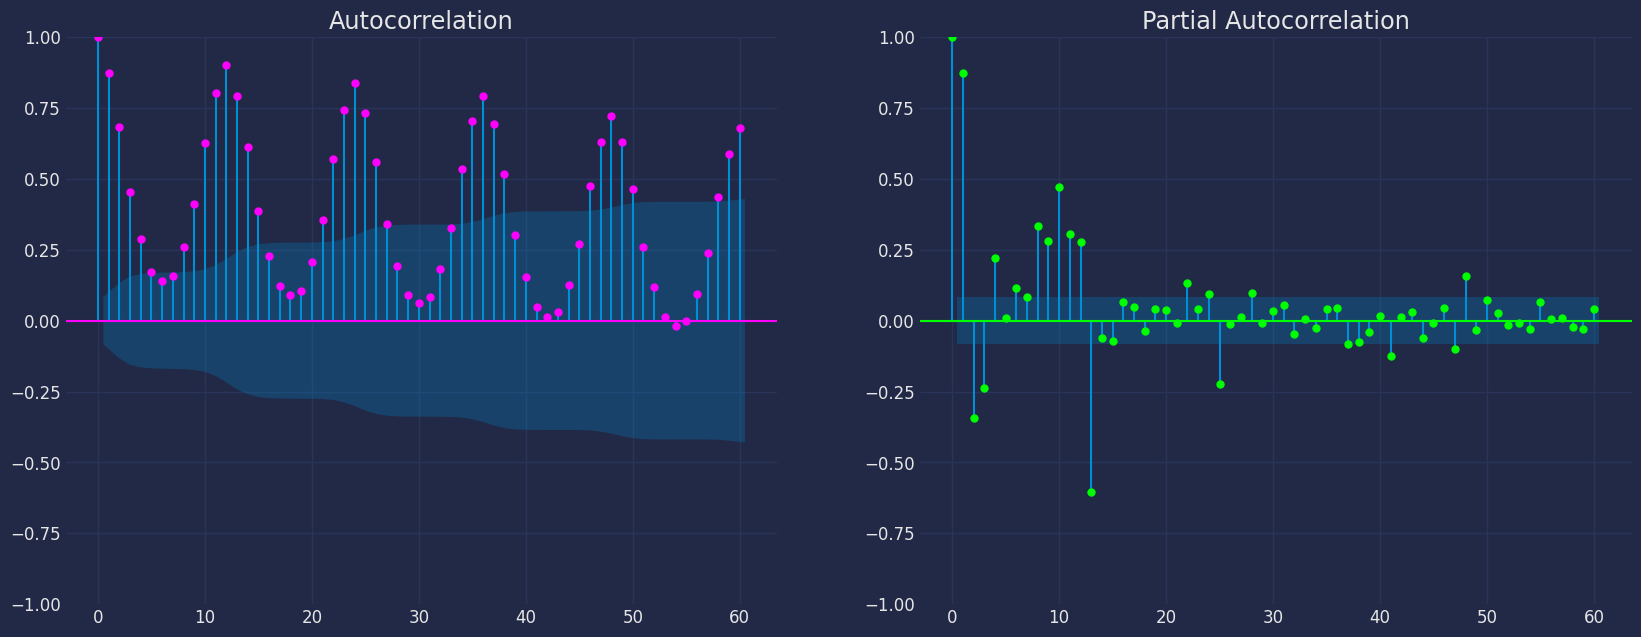

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets
1. Data to train our `AutoTheta` model
2. Data to test our model

For the test data we will use the last 12 months to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2016-08-01'] 
test = df[df.ds>'2016-08-01']

In [ ]:
train.shape, test.shape

((536, 3), (12, 3))

Now let's plot the training data and the test data.

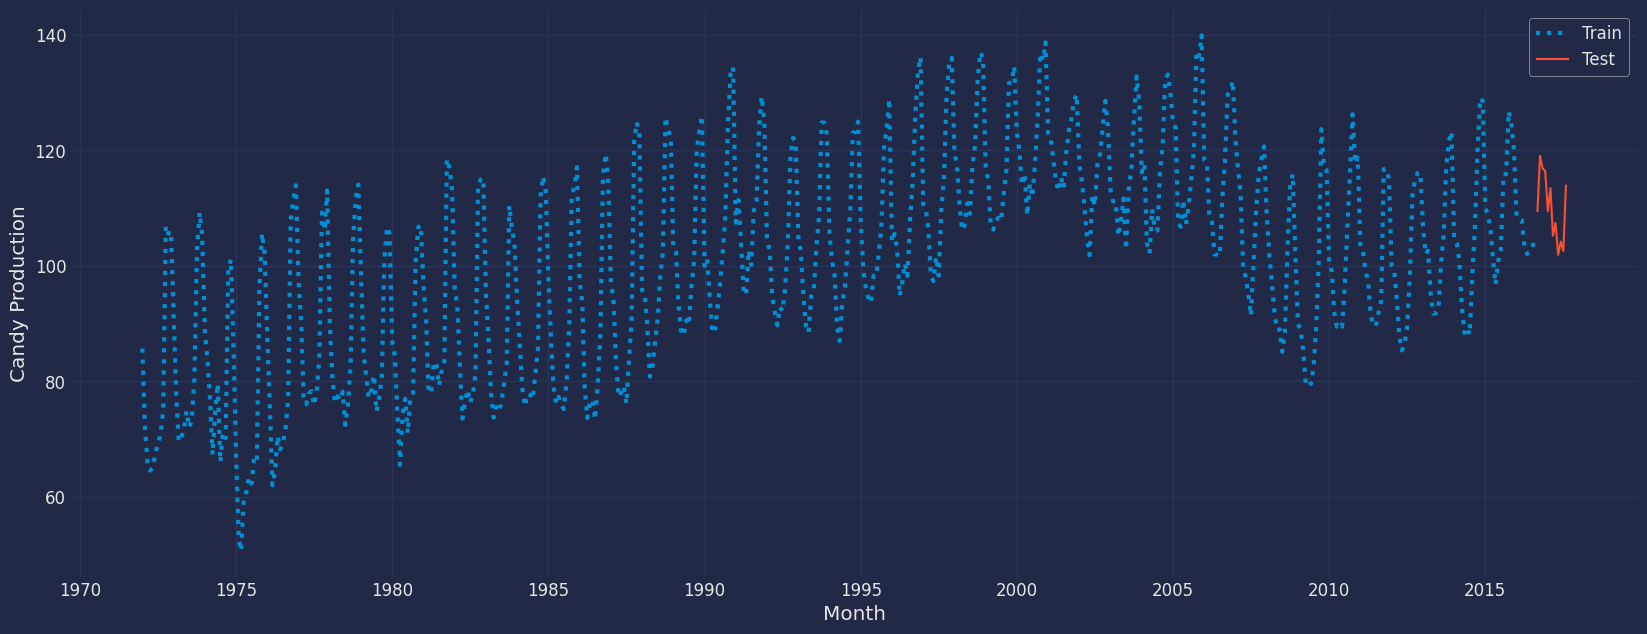

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train", linewidth=3, linestyle=":")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.ylabel("Candy Production")
plt.xlabel("Month")
plt.show()

## Implementation of AutoTheta with StatsForecast <a class="anchor" id="implementation"></a>

To also know more about the parameters of the functions of the `AutoTheta Model`, they are listed below. For more information, visit the [documentation](https://nixtla.github.io/statsforecast/src/core/models.html#automatic-forecasting)

```
season_length : int
    Number of observations per unit of time. Ex: 24 Hourly data.
decomposition_type : str
    Sesonal decomposition type, 'multiplicative' (default) or 'additive'.
model : str
    Controlling Theta Model. By default searchs the best model.
alias : str
    Custom name of the model.
```

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoTheta

### Instantiate Model

Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful.season_length.

Automatically selects the best Theta (Standard Theta Model `(‘STM’)`, Optimized Theta Model `(‘OTM’)`, Dynamic Standard Theta Model `(‘DSTM’)`, Dynamic Optimized Theta Model `(‘DOTM’))` model using mse.

In [ ]:
season_length = 12 # Monthly data 
horizon = len(test) # number of predictions

# We call the model that we are going to use
models = [AutoTheta(season_length=season_length,
                     decomposition_type="additive",
                     model="STM")]
                    

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [panda’s available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(df=train,
                   models=models,
                   freq='MS', 
                   n_jobs=-1)

### Fit Model

In [ ]:
sf.fit()

StatsForecast(models=[AutoTheta])

Let's see the results of our Theta model. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
result

{'mse': 100.64880011735451,
 'amse': array([19.1126859 , 31.8559999 , 38.50771628]),
 'fit': results(x=array([258.45065328,   0.7664297 ]), fn=100.57831804495909, nit=32, simplex=array([[250.37338839,   0.76970741],
        [232.0391584 ,   0.76429422],
        [258.45065328,   0.7664297 ]])),
 'residuals': array([ 2.10810474e+00, -1.13894116e+01, -9.49139749e+00, -9.82041058e+00,
        -1.13263190e+01, -9.25797072e+00, -8.56619271e+00, -8.99232281e+00,
        -1.98586635e+00,  3.14569304e+01,  1.98520670e+01,  2.04962612e+01,
         4.98121093e+00, -1.08735318e+01, -1.12328034e+01, -8.08115311e+00,
        -9.98197694e+00, -8.39937079e+00, -1.25789510e+01, -1.05952806e+01,
         8.47229675e-01,  2.25644626e+01,  2.54401518e+01,  1.73989709e+01,
         2.40287622e+00, -2.53475414e+00, -8.00590851e+00, -1.79241485e+01,
        -6.36590415e+00, -5.76986711e+00, -2.26766747e+01, -8.95260757e+00,
        -7.19719238e+00,  2.74032221e+01,  2.21368465e+01,  6.43171918e+00,
        

Let us now visualize the residuals of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,2.108105
1,-11.389412
2,-9.491397
...,...
533,-12.076382
534,-10.073893
535,-9.392075


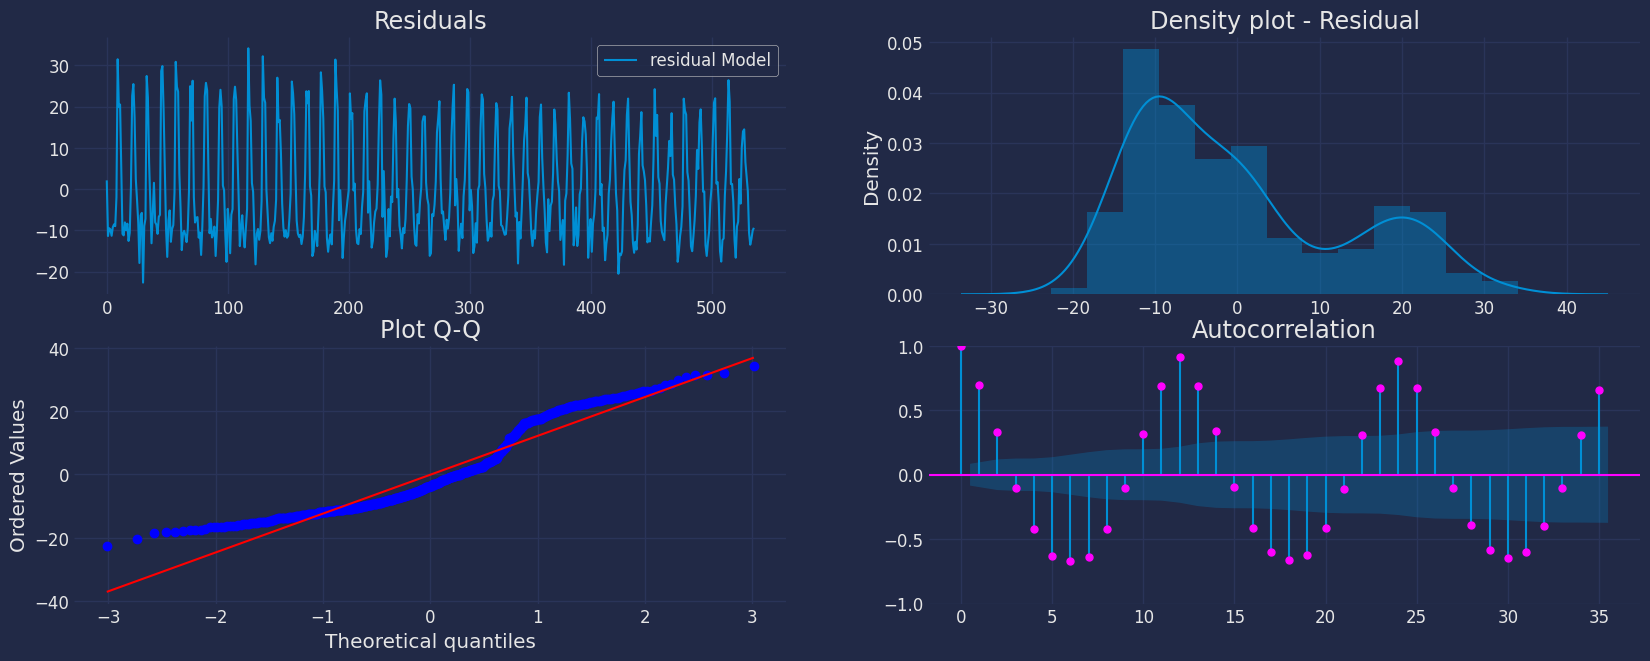

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2)

residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like `ARIMA` and `Theta`)

In [ ]:
# Prediction
Y_hat = sf.forecast(horizon, fitted=True)

Y_hat

,ds,AutoTheta
unique_id,,
1,2016-09-01,111.075912
1,2016-10-01,129.111282
1,2016-11-01,131.296082
...,...,...
1,2017-06-01,101.125748
1,2017-07-01,99.870514
1,2017-08-01,106.021683


In [ ]:
values=sf.forecast_fitted_values()
values.head()

,ds,y,AutoTheta
unique_id,,,
1,1972-01-01,85.694504,83.586395
1,1972-02-01,71.820000,83.209412
1,1972-03-01,66.022903,75.514297
1,1972-04-01,64.564499,74.384911
1,1972-05-01,65.010002,76.336319


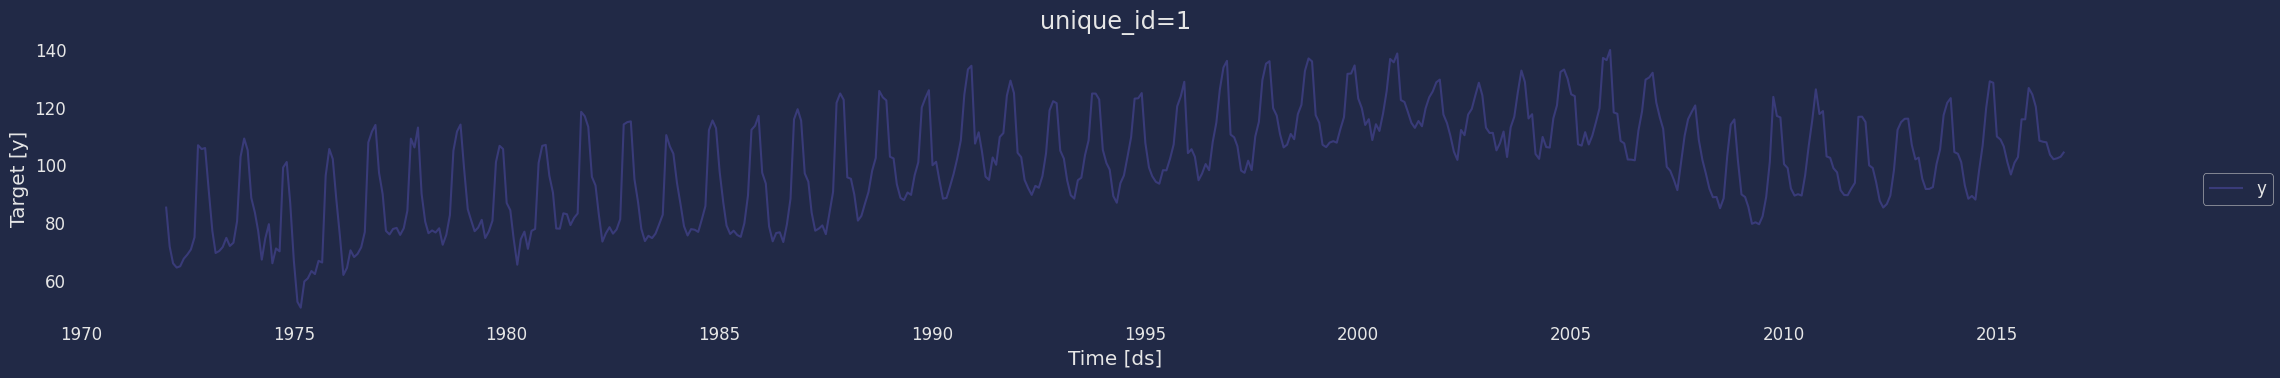

In [ ]:
StatsForecast.plot(values)

Adding 95% confidence interval with the forecast method

In [ ]:
sf.forecast(h=horizon, level=[95])

,ds,AutoTheta,AutoTheta-lo-95,AutoTheta-hi-95
unique_id,,,,
1,2016-09-01,111.075912,90.148819,135.999680
1,2016-10-01,129.111282,94.811134,160.372803
1,2016-11-01,131.296082,90.598457,168.251602
...,...,...,...,...
1,2017-06-01,101.125748,41.213715,159.133316
1,2017-07-01,99.870514,35.173969,152.843002
1,2017-08-01,106.021683,38.784256,166.021072


In [ ]:
Y_hat=Y_hat.reset_index()
Y_hat

,unique_id,ds,AutoTheta
0,1,2016-09-01,111.075912
1,1,2016-10-01,129.111282
2,1,2016-11-01,131.296082
...,...,...,...
9,1,2017-06-01,101.125748
10,1,2017-07-01,99.870514
11,1,2017-08-01,106.021683


In [ ]:
# Merge the forecasts with the true values
test['unique_id'] = test['unique_id'].astype(int)
Y_hat1 = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])
Y_hat1

,ds,y,unique_id,AutoTheta
0,2016-09-01,109.3191,1,111.075912
1,2016-10-01,119.0502,1,129.111282
2,2016-11-01,116.8431,1,131.296082
...,...,...,...,...
9,2017-06-01,104.2022,1,101.125748
10,2017-07-01,102.5861,1,99.870514
11,2017-08-01,114.0613,1,106.021683


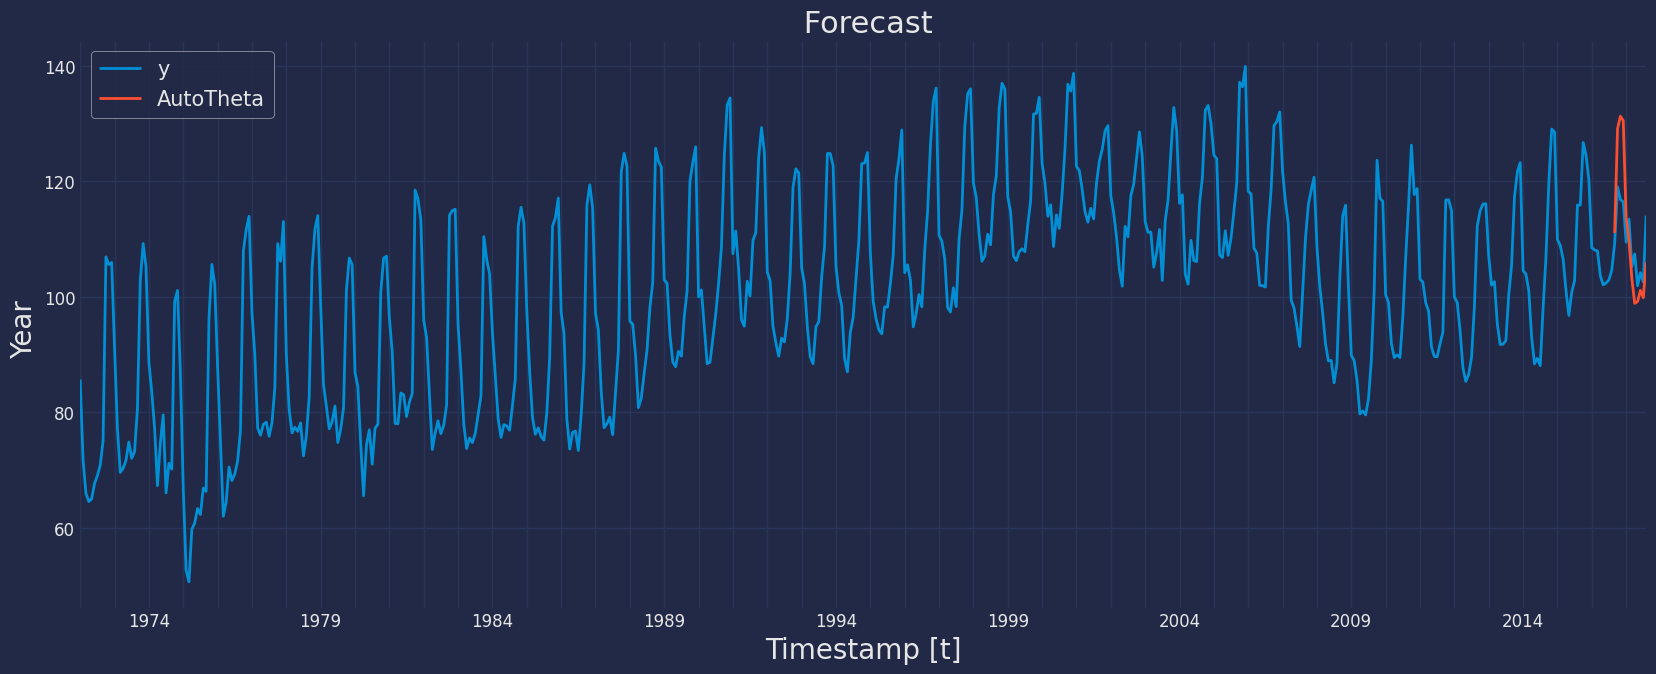

In [ ]:
fig, ax = plt.subplots(1, 1)
plot_df = pd.concat([train, Y_hat1]).set_index('ds')
plot_df[['y', "AutoTheta"]].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Year ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
sf.predict(h=horizon) 

,ds,AutoTheta
unique_id,,
1,2016-09-01,111.075912
1,2016-10-01,129.111282
1,2016-11-01,131.296082
...,...,...
1,2017-06-01,101.125748
1,2017-07-01,99.870514
1,2017-08-01,106.021683


In [ ]:
forecast_df = sf.predict(h=horizon, level=[95]) 

forecast_df

,ds,AutoTheta,AutoTheta-lo-95,AutoTheta-hi-95
unique_id,,,,
1,2016-09-01,111.075912,90.148819,135.999680
1,2016-10-01,129.111282,94.811134,160.372803
1,2016-11-01,131.296082,90.598457,168.251602
...,...,...,...,...
1,2017-06-01,101.125748,41.213715,159.133316
1,2017-07-01,99.870514,35.173969,152.843002
1,2017-08-01,106.021683,38.784256,166.021072


We can join the forecast result with the historical data using the pandas function `pd.concat()`, and then be able to use this result for graphing.

In [ ]:
pd.concat([df, forecast_df]).set_index('ds')

,y,unique_id,AutoTheta,AutoTheta-lo-95,AutoTheta-hi-95
ds,,,,,
1972-01-01,85.6945,1,NaN,NaN,NaN
1972-02-01,71.8200,1,NaN,NaN,NaN
1972-03-01,66.0229,1,NaN,NaN,NaN
...,...,...,...,...,...
2017-06-01,NaN,NaN,101.125748,41.213715,159.133316
2017-07-01,NaN,NaN,99.870514,35.173969,152.843002
2017-08-01,NaN,NaN,106.021683,38.784256,166.021072


Now let's visualize the result of our forecast and the historical data of our time series, also let's draw the confidence interval that we have obtained when making the prediction with 95% confidence.

In [ ]:
def plot_forecasts(y_hist, y_true, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(12*10)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2)
    colors = ['orange', 'black', 'green']
    for model, color in zip(models, colors):
        ax.fill_between(df_plot.index, 
                        df_plot[f'{model}-lo-95'], 
                        df_plot[f'{model}-hi-95'],
                        alpha=.35,
                        color=color,
                        label=f'{model}-level-95')
    ax.set_title('', fontsize=22)
    ax.set_ylabel('', fontsize=20)
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid(True)

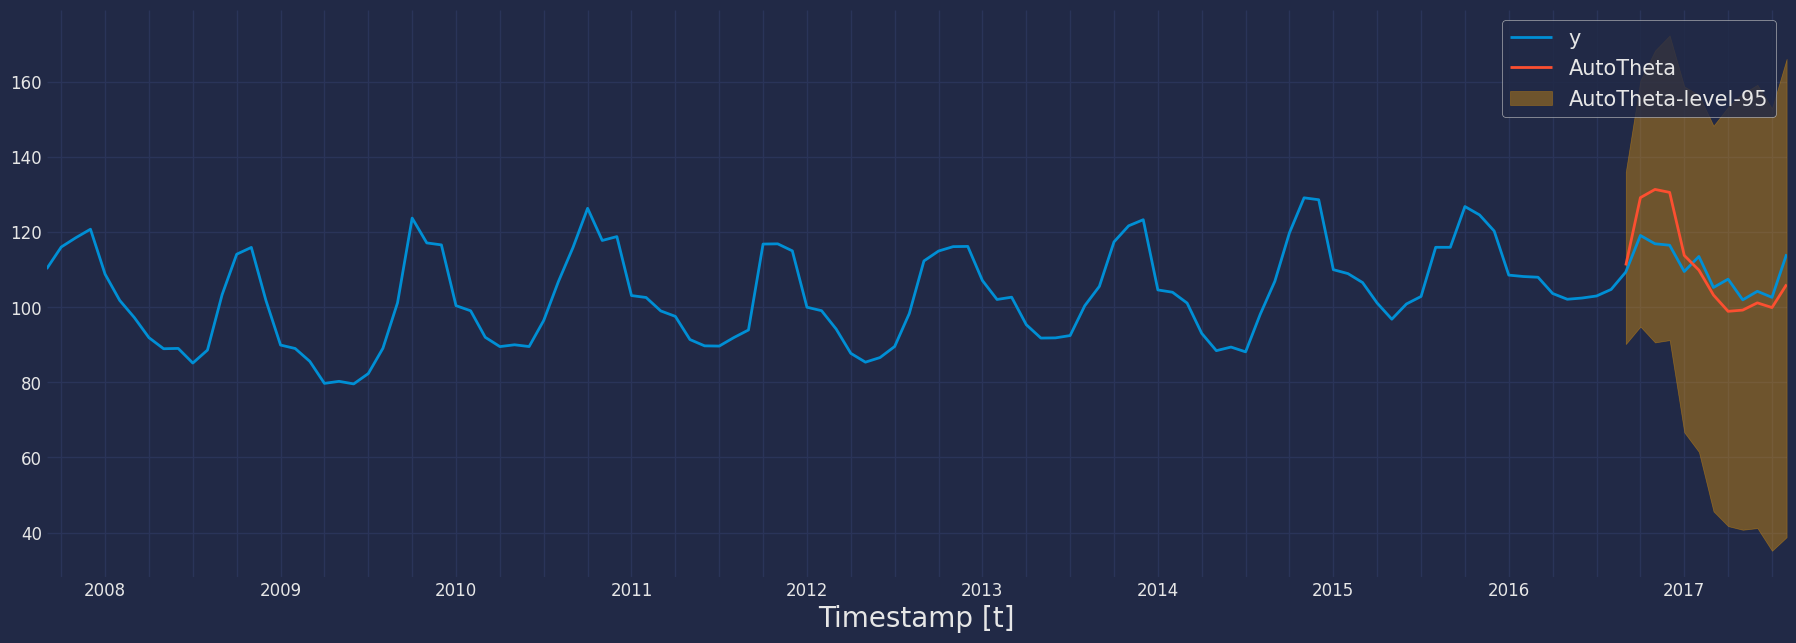

In [ ]:
plot_forecasts(train, test, forecast_df, models=['AutoTheta'])

Let's plot the same graph using the plot function that comes in `Statsforecast`, as shown below.

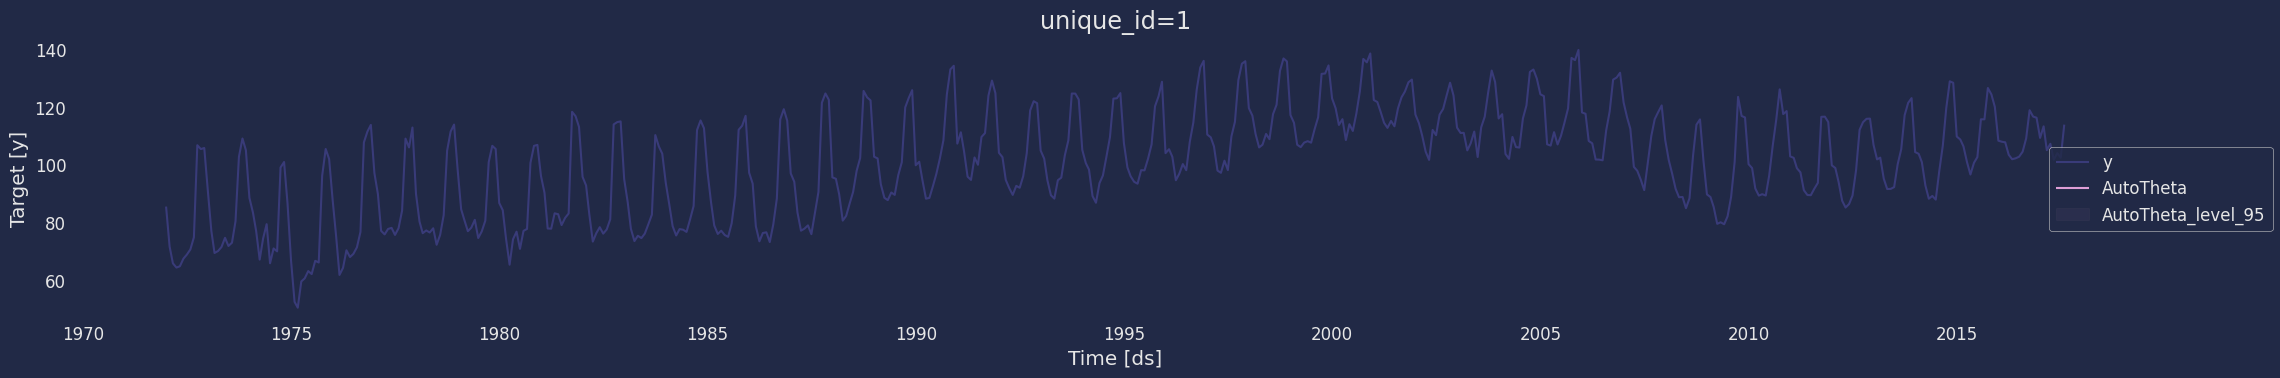

In [ ]:
sf.plot(df, forecast_df, level=[95])

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=5)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=train,
                                         h=horizon,
                                         step_size=12,
                                         n_windows=5)

The crossvaldation_df object is a new data frame that includes the following columns:

*  `unique_id:` index. If you dont like working with index just run crossvalidation_df.resetindex()
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the n_windows.
* `y:` true value
* `"model":` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,ds,cutoff,y,AutoTheta
unique_id,,,,
1,2011-09-01,2011-08-01,93.906197,98.167465
1,2011-10-01,2011-08-01,116.763397,116.969933
1,2011-11-01,2011-08-01,116.825798,119.135147
...,...,...,...,...
1,2016-06-01,2015-08-01,102.404404,109.600456
1,2016-07-01,2015-08-01,102.951202,108.260147
1,2016-08-01,2015-08-01,104.697701,114.248260


## Model Evaluation <a class="anchor" id="evaluate"></a>

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to `install datasetsforecast`, a Python library developed **by Nixtla** that includes a function to compute the RMSE.

In [ ]:
%%capture
!pip install datasetsforecast

In [ ]:
from datasetsforecast.losses import rmse

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case, AutoTheta.

In [ ]:
rmse = rmse(crossvalidation_df['y'], crossvalidation_df["AutoTheta"])
print("RMSE using cross-validation: ", rmse)

RMSE using cross-validation:  6.9269824


As you have noticed, we have used the cross validation results to perform the evaluation of our model.

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics `MAE, MAPE, MASE, RMSE, SMAPE` to evaluate the `accuracy`.

In [ ]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)

In [ ]:
def evaluate_performace(y_hist, y_true, y_pred, model):
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    evaluation[model] = {}
    for metric in [mase, mae, mape, rmse, smape]:
        metric_name = metric.__name__
        if metric_name == 'mase':
            evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                y_true[model].values, 
                                                y_hist['y'].values, seasonality=12)
        else:
            evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [ ]:
evaluate_performace(train, test, Y_hat, model="AutoTheta")

,mae,mape,mase,rmse,smape
AutoTheta,6.281525,5.568355,1.212475,7.683672,5.479727


## Acknowledgements

We would like to thank [Naren Castellon](https://www.linkedin.com/in/naren-castellon-1541b8101/?originalSubdomain=pa) for writing this tutorial.

## References <a class="anchor" id="references"></a>

1. [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). “Models for optimising the theta method and their relationship to state space models”. International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243).
2. [Nixtla Parameters](https://nixtla.github.io/statsforecast/src/core/models.html#autotheta).
3. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
4. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
5. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).